### Machine Learning Group Project


### Teammembers and Contribution

Wong Tung Tung 56221080 
- designed Model XY

Ng Cheuk Fai 55818427 
- designed XceptionModel

Dario Bogenreiter 40143681 
- wrote Step 0.1 0.2.1, 0.2.2, 0.2.3
- wrote Step 1
- wrote Step 2
- wrote Step 3.2.1, 3.2.2, 3.2.3, 3.2.4
- designed the structure of the notebook

# Step 0. Prereqesites

## 0.1 Load necessary libraries

In [1]:
%%capture

# standard libraries
import pandas as pd
import numpy as np
from numpy import *
import sys

# for visuals
import matplotlib.pyplot as plt 
import matplotlib

# handling files
import zipfile
import os
import fnmatch
import regex as re

# dealing with images
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import skimage
import cv2
from skimage import img_as_ubyte
from PIL import Image
from sklearn import *
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.utils import compute_class_weight

#for cleaning up memory
import gc

#for deleting files
import shutil

#for shuffeling the data
import random
from sklearn.utils import shuffle

#for model visuals
!pip install visualkeras
import visualkeras

#for deep learning
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.layers.serialization import populate_deserializable_objects
from tensorflow.keras.utils import Sequence

# traditional models
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

In [2]:
#note I had to run the file on google colab since my processor was too weak
from google.colab import drive

#connect to google drive
drive.mount("/content/gdrive", force_remount=True)
%cd gdrive/My\ Drive/Colab_Notebooks/ML/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab_Notebooks/ML


## 0.2 Defining functions

### 0.2.1. Data Loading functions

In [3]:
def create_data_split_and_directory(train_val_test_split = (0.8, 0.1, 0.1), extract_zip=False):
    """ The following takes the orignal data from a zip or a folder
    and creates approciates directory strucutre with files
    given a split """

    # unzip the orignal data into directory if not already done
    if extract_zip:
      if 'unzipped_data' in os.listdir():
        shutil.rmtree('./unzipped_data/')
      with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
          zip_ref.extractall('./unzipped_data/')
    else:
      pass

    # create data structure
    # delete previous data folder if there was
    # already one earlier, enables us to create new splits easily
    if 'data' in os.listdir():
      shutil.rmtree('./data/')
    # create the folders 
    os.mkdir('./data/')
    os.mkdir('./data/train/')
    os.mkdir('./data/val/')
    os.mkdir('./data/test/')
    # for all subsets create folders to store the label information
    for sub_directory in os.listdir('./data/'):
      os.mkdir('./data/' + sub_directory + '/original/')
      os.mkdir('./data/' + sub_directory + '/manipulated/')

    # open all file names from original data
    all_manipulated_files = []
    all_original_files = []
    for path, subdir, files in os.walk('./unzipped_data/data/'):
        for name in files:
              if fnmatch.fnmatch(name, "*.png"):
                  if "original" in path:
                      all_original_files.append(os.path.join(path, name))
                  elif "manipulated" in path:
                      all_manipulated_files.append(os.path.join(path, name))

    # shuffle the data
    random.shuffle(all_original_files)
    random.shuffle(all_manipulated_files)

    # split the data by moving it into a new directory
    # the try loops are just a precaustion in case
    # we can not evenly split the data
    sub_set_num = 0
    num_all_manipulated = int(len(all_manipulated_files))
    num_all_originals = int(len(all_original_files))
    for data_sub_set in ['train', 'val', 'test']:
      s_to_move = int(num_all_manipulated*train_val_test_split[sub_set_num])
      for file in all_manipulated_files[0:s_to_move]:
        try:
          shutil.copy(file, './data/' + data_sub_set + '/manipulated/') 
        except:
          print(file)
          pass
      all_manipulated_files = all_manipulated_files[s_to_move:]
      
      s_to_move = int(num_all_originals*train_val_test_split[sub_set_num])
      for file in all_original_files[0:s_to_move]:
        try:
          shutil.copy(file, './data/' + data_sub_set + '/original/')
        except:
          print(file)
          pass
      all_original_files = all_original_files[s_to_move:]

      sub_set_num = sub_set_num + 1

def load_color_image(path, imagesize):
    """ simple function
    to open an image from path as color image"""
    # open file
    image = cv2.imread(path)
    # change color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # change size
    image = cv2.resize(image, imagesize)
    return image

def load_bw_image(path, imagesize):
    """ simple function
    to open an image from path as black and white image"""
    # parse it as image parse image as bw image
    sk_bw_image = skimage.io.imread(path, as_gray=True)
    # change size of bw image
    image = resize(sk_bw_image, imagesize, anti_aliasing=True)
    return image
      
def load_data(imagesize, path = './data/', bw = False):
    """
    The main functionality to load images as numpy array given a datapath
    Paramater imagesize is a 1x2 array indicating how big the
    loaded image should be, bw meaning if black and white pictures should be loaded.
    """

    # define the datasets
    trainX = []
    trainY = []
    # array to tell us the type of fake
    trainType = []
    valX = []
    valY = []
    valType = []
    testX = []
    testY = []
    testType = []

    if bw == True:
      image_loader = load_bw_image
    else:
      image_loader = load_color_image

    for data_sub_set in ['train', 'val', 'test']:
      for encoded_class, class_name in enumerate(['original', 'manipulated']):
        for path, subdir, files in os.walk('./data/' + data_sub_set + '/' + class_name + '/'):
          for name in files:
                loaded_image = image_loader(os.path.join(path, name), imagesize)
                eval(data_sub_set + 'X' + '.append(loaded_image)')
                eval(data_sub_set + 'Y' + '.append(encoded_class)')
                eval(data_sub_set + 'Type' + '.append(re.sub("\d+\.png", "original", (name.split("_")[0])))')
    
    # convert to numpy arrays
    trainX = np.array(trainX, dtype = 'float32')  
    trainY = np.array(trainY, dtype = 'int32')
    valX = np.array(valX, dtype = 'float32') 
    valY = np.array(valY, dtype = 'int32')
    testX = np.array(testX, dtype = 'float32')
    testY = np.array(testY, dtype = 'int32')

    # returning scaled images
    return trainX/255, trainY, trainType, valX/255, valY, valType, testX/255, testY, testType

### 0.2.2. Function for Data Analytics

In [4]:
def plot_class_examples(num_examples, images, labels, image_types):
  """ function to plot n example of the two classes
  (orginal and modified ) in our dataset """

  #filter data
  imag_indx_o = np.where(labels == 0)[0][0:num_examples]
  originals = images[imag_indx_o]
  imag_indx_f = np.where(labels == 1)[0][0:num_examples]
  fakes_index = imag_indx_f.tolist()

  # create figure
  fig = plt.figure(figsize=(num_examples*2, 5))
    
  # setting values to rows and column variables
  rows = 2
  columns = num_examples

  position = 1
  for i in originals: 
    fig.add_subplot(rows, columns, position)
    plt.imshow(i)
    plt.title("Orignal Img #"+ str(position))
    plt.axis('off')
    position = position +1

  for index in fakes_index: 
    fig.add_subplot(rows, columns, position)
    plt.imshow(images[index])
    plt.title("Fake of Type\n" + image_types[index])
    plt.axis('off')
    position = position +1

def plot_types(pictures, types):
  """ a function to plot the different 
  type of fakes """
  # create figure
  fig = plt.figure(figsize=(len(pictures)*2, 5))
    
  # setting values to rows and column variables
  rows = 1
  columns = len(pictures)

  position = 1
  for i, pic in enumerate(pictures): 
    fig.add_subplot(rows, columns, position)
    plt.imshow(pic)
    plt.title(types[i] + " Img #"+ str(position))
    plt.axis('off')
    position = position +1


def create_bar_plot(input_Array, title = "Distribution of Types"):
  """
  A simple function to create a bar plot
  based on value counts for a given input array"""

  plt.figure(figsize = (4,3), dpi = 100)
  plt.style.use("seaborn")
  plt.title(title)
  plt.ylabel("Number of Instances")
  plt.xlabel("Image Type")
  pd.Series(input_Array).value_counts().plot(kind="bar")
  _ = plt.xticks(rotation=30)

### 0.2.3. Functions for Visualization & Evaluation of Results

In [41]:

def visualize_prediction(Y, Y_hat, Model_Name, 
                         class_names = ["original", "modified"]):
    """basic function to create confusion matrix
    for predicted and actual values of a model
    and visualize it"""
    
    confusion_matrix = metrics.confusion_matrix(Y, Y_hat)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)
    cm_display.plot(cmap = 'Blues', ax = plt.figure(figsize=(2.5,2), dpi=100).add_axes([0, 0, 1, 1])) 
    plt.grid(False)
    plt.title("Confusion Matrix of the " + Model_Name)
    plt.xticks(rotation=40)
    plt.show() 
        
    print("----------------------------------------------------------------")

def evaluate_model(Model, Model_Name, class_names, testX, testY, 
                   trainY = None, trainX = None, skip_train=True):
  
    """ Function to predict values via a given model
    for training and/or test data and then visualizing the results
    """
    
    for i in [[trainX, trainY, "Train"], [testX, testY, "Test"]]:
        X = i[0]
        Y = i[1]
        Set_Name = i[2]
        
        if skip_train == True and Set_Name == "Train":
            continue
        
        print("----------------------------------------------------------------")
        print("Evaluation of " + Model_Name + " on " + Set_Name +  "-Set")

        #doing the prediction
        Y_hat = Model.predict(X)
        #predYtest[Model_Name] = Y_hat

        if "keras.engine" in str(type(Model)):
          Y_hat = np.array(np.round_(Y_hat, decimals = 0, out = None), dtype="int32")
          Y_hat = np.array([x[0] for x in Y_hat.tolist()], dtype="int32")
        
        #outputing accuracy, recall precision and AUC
        accuracy = metrics.accuracy_score(Y, Y_hat)
        recall = metrics.recall_score(Y, Y_hat)
        precision = metrics.precision_score(Y, Y_hat)
        AUC = metrics.roc_auc_score(Y, Y_hat)
        print("Accuracy Score: {:.2f}".format(accuracy))
        print("Recall Score: {:.2f}".format(recall))
        print("Precision Score: {:.2f}".format(precision))
        print("AUC: {:.2f}".format(AUC))
        
        # outputting visual illustration
        visualize_prediction(Y, Y_hat, Model_Name)
        
    print("----------------------------------------------------------------")
    return Y_hat, accuracy, recall, precision, AUC


def plot_training(training_data,train,validation):
    """ Function to visualize the training process
    of a neural network - plots training accuracy
    against validation accuracy """
    plt.style.use('seaborn')
    plt.figure(figsize=(8,3), dpi=80)
    plt.plot(training_data.history[train], color='#6461c2')
    plt.plot(training_data.history[validation], color='#ee0000')
    plt.title('Learning Progress')
    plt.ylabel(train)
    plt.xticks(np.arange(0,len(training_data.history[train]), step=3), 
               np.arange(1,len(training_data.history[train]),  step = 3),  size=13)
    plt.yticks(size=13)
    plt.xlabel('Epoch', size = 13)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


def plot_right_and_wrong_predictions(predYtest, testY, testType, num_examples=5):
    """ A function to plot actual images of examples of 
    correctly and misclassified pictures """

    # get indices of misclassified test images
    ind_bad = np.where(predYtest != testY)[0]
    badimgs = testX[ind_bad][0:num_examples]

    # get indices of correctly classified test images
    ind_good = np.where(predYtest == testY)[0]
    goodimg = testX[ind_good][0:num_examples]

    # create figure
    fig = plt.figure(figsize=(num_examples*1.5, 3.5))
      
    # setting values to rows and column variables
    rows = 2
    columns = num_examples

    #plot positive example
    position = 1
    for i in goodimg: 
      fig.add_subplot(rows, columns, position)
      plt.imshow(i)
      plt.title("Correct \n Prediction #"+ str(position), fontsize=8)
      plt.axis('off')
      position = position +1

    #plot negative examples
    for i in badimgs: 
      fig.add_subplot(rows, columns, position)
      plt.imshow(i)
      plt.title("Wrong \n Prediction #"+ str(position-num_examples), fontsize=8)
      plt.axis('off')
      position = position +1
  
    # visualize how many misclassified we have per image type
    badimgs_types = np.array(testType)[ind_bad]
    #create_bar_plot(badimgs_types)
    #create_bar_plot(testType)
    plt.style.use("seaborn")
    df = pd.DataFrame({'total_samples': pd.Series(testType).value_counts(),
                       'prediction_mistakes':  pd.Series(badimgs_types).value_counts(),
                      }, index=np.unique(testType))

    df.plot(kind="bar", figsize = (5,3))
    plt.title("Prediction Error per Image Type")
    plt.ylabel("Number of Instances")
    plt.xlabel("Image Type")
    plt.rcParams["figure.dpi"] = 120
    _ = plt.xticks(rotation=30)


# Step 1: Data Loading

In [ ]:
#create_data_split_and_directory(train_val_test_split = (0.7, 0.2, 0.1), extract_zip=True)

In [8]:
#loading the dataset
imagesize = (160,160)
trainX, trainY, trainType, valX, valY, valType, testX, testY, testType = load_data(imagesize)

In [ ]:
#save to pickle file so we can reload the data more quickly
#with open('saved_data.npy', 'wb') as f:
  #  np.save(f,trainX)
 #   np.save(f,trainY)
  #  np.save(f,trainType)
  #  np.save(f,valX)
 #   np.save(f,valY)
  #  np.save(f,valType)
  #  np.save(f,testX)
  #  np.save(f,testY)
  #  np.save(f,testType)

In [ ]:
#with open('saved_data.npy', 'rb') as f:

  #  trainX = np.load(f)
  #  trainY = np.load(f)
  #  trainType = np.load(f)
  #  valX = np.load(f)
  #  valY = np.load(f)
   # valType = np.load(f)
   # testX = np.load(f)
   # testY = np.load(f)
   # testType= np.load(f)

In [9]:
# shuffling the data again 
trainX, trainY, trainType = shuffle(trainX, trainY, trainType)
valX, valY, valType = shuffle(valX, valY, valType)
testX, testY, testType = shuffle(testX, testY, testType)
valY[0:10]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

# Step 2: Data Analytics

Ratio of Manipulated Pictures in Dataset: 0.6666666666666666


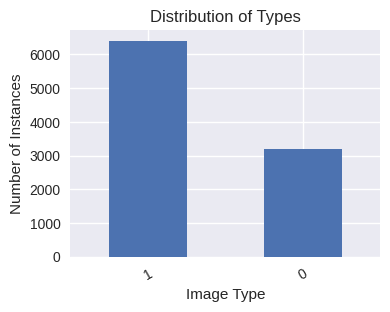

In [ ]:
create_bar_plot(trainY)

print("Ratio of Manipulated Pictures in Dataset: " + str(np.count_nonzero(trainY== 1)  / (np.count_nonzero(trainY== 0)+np.count_nonzero(trainY== 1))))

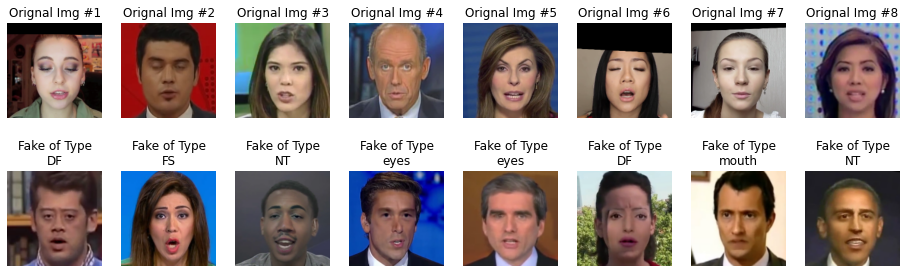

In [ ]:
plot_class_examples(8, trainX, trainY, trainType)

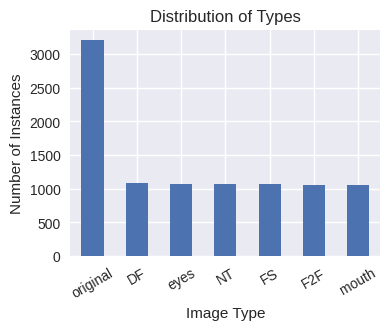

In [ ]:
create_bar_plot(trainType)

# Step 3. Building Models

## Step 3.1. Traditional Models

### 3.1.0 Data Load and Preprocessing

**Loading the data**

In [ ]:
trainX_bw, trainY, trainType, valX_bw, valY, valType, testX_bw, testY, testType = load_data(imagesize, bw=True)

**Image Flattening & Normalization**

In [ ]:
def flatten_and_normalize(image_array):
  #flattening
  flat_X = empty((len(image_array), prod(imagesize)))
  for i,img in enumerate(image_array):
      flat_X[i,:] = ravel(img)

  #normalization
  scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))  
  flat_X = scaler.fit_transform(flat_X) 
  return flat_X

trainX_bw = flatten_and_normalize(trainX_bw)
valX_bw = flatten_and_normalize(valX_bw)
testX_bw = flatten_and_normalize(testX_bw)

**Do Dimenstionality Reduction**

In [ ]:
#pca = decomposition.PCA(n_components=50)

svd = decomposition.TruncatedSVD(n_components=250)
#transformed x data
trainX_bw_svd = svd.fit_transform(trainX_bw)
trainX_bw_svd  = svd.transform(trainX_bw)
testX_bw_svd  = svd.transform(testX_bw)

### 3.1.1 Cross Validation Search

In [ ]:
clfs = {}
# setup all the parameters and models
exps = {
    #'svm-lin': {
     #   'paramgrid': {'C': logspace(-2,3,5)},
      #  'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,5), 'gamma': logspace(-4,3,5) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [3,4]},
        'clf': svm.SVC(kernel='poly') },
    }

def do_cross_validation_search(exps, trainX, trainY):

  for model_name in exps.keys():
      paramgrid = exps[model_name]['paramgrid']
      estimator = exps[model_name]['clf']

      clf = model_selection.GridSearchCV(estimator, paramgrid, cv=10, n_jobs=-1)
      clf.fit(trainX, trainY)
      print("Best cross-validation for {} score is: {:.3f}, with parameters {} ".format(
                                                                              model_name,
                                                                              clf.best_score_, 
                                                                              clf.best_params_))
      #clfs[model_name] = clf
do_cross_validation_search(exps, trainX_bw_svd, trainY)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

In [ ]:
#build model
SVM_poly = svm.SVC(kernel='poly', C = 0.129, degree=3)
SVM_poly.fit(trainX_bw_svd, trainY)

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

----------------------------------------------------------------
Evaluation of SVM Poly on Test-Set
Accuracy Score: 0.67
Recall Score: 1.00
Precision Score: 0.67
AUC: 0.50


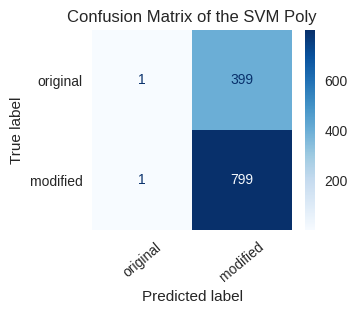

----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
evaluate_model(SVM_poly, "SVM Poly", ["original", "modified"],
               testX_bw_svd, testY)

In [ ]:
exps2 = {
    'knn': {
        'paramgrid': {'n_neighbors': arange(2,50,2)},
        'clf': neighbors.KNeighborsClassifier() },
    }

do_cross_validation_search(exps2, trainX_bw_svd, trainY)


Best cross-validation for knn score is: 0.658, with parameters {'n_neighbors': 48} 


----------------------------------------------------------------
Evaluation of K Nearest Neighbour on Test-Set
Accuracy Score: 0.66
Recall Score: 0.97
Precision Score: 0.67
AUC: 0.50


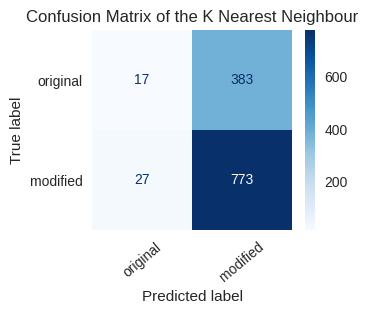

----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=48)
knn.fit(trainX_bw_svd, trainY)
evaluate_model(knn, "K Nearest Neighbour", ["original", "modified"], 
               testX_bw_svd, testY)

In [ ]:
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(trainX_bw_svd, testX_bw_svd, 
                              trainY, testY)
models

100%|██████████| 29/29 [02:47<00:00,  5.78s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.56,0.55,0.55,0.57,0.11
QuadraticDiscriminantAnalysis,0.59,0.54,0.54,0.59,0.33
Perceptron,0.61,0.54,0.54,0.60,0.14
LinearSVC,0.66,0.54,0.53,0.60,8.39
NuSVC,0.61,0.53,0.53,0.59,24.32
KNeighborsClassifier,0.60,0.52,0.52,0.59,0.34
LinearDiscriminantAnalysis,0.65,0.52,0.52,0.58,0.48
RidgeClassifierCV,0.66,0.52,0.52,0.58,0.34
RidgeClassifier,0.66,0.52,0.52,0.58,0.13


#### Upsampling the Data

In [ ]:
trainX_bw_svd_upsampled = np.append(trainX_bw_svd, trainX_bw_svd[np.where(trainY==0)[0]], axis=0)
trainY_upsampled = np.append(trainY, trainY[np.where(trainY==0)[0]], axis=0)
print(len(np.where(trainY_upsampled==0)[0]))
print(len(np.where(trainY_upsampled==1)[0]))

6400
6400


In [ ]:
models, predictions = clf.fit(trainX_bw_svd_upsampled, testX_bw_svd, 
                              trainY_upsampled, testY)
models

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [04:18<00:00,  8.92s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RidgeClassifierCV,0.56,0.56,0.56,0.57,0.49
RidgeClassifier,0.56,0.56,0.56,0.57,0.18
LinearDiscriminantAnalysis,0.56,0.56,0.56,0.57,0.63
NuSVC,0.59,0.56,0.56,0.60,55.37
LogisticRegression,0.55,0.55,0.55,0.57,0.18
NearestCentroid,0.55,0.55,0.55,0.57,0.14
CalibratedClassifierCV,0.55,0.55,0.55,0.56,46.72
SVC,0.57,0.55,0.55,0.58,30.99
BernoulliNB,0.56,0.54,0.54,0.57,0.17


## Step 3.2. Deep Learning

### 3.2.0 Preperation

**Cleaning Up Memory**

In [ ]:

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        trainX:  2.7 GiB
                          valX: 351.6 MiB
                         testX: 351.6 MiB
                     trainType: 76.0 KiB
                        trainY: 37.6 KiB
                       valType: 10.0 KiB
                      testType: 10.0 KiB
                           _i3:  4.9 KiB
                          valY:  4.8 KiB
                         testY:  4.8 KiB


In [ ]:
#del reduced_trainX
#del reduced_testX

gc.collect()

49169

**Setting up the Batch Generator**

In [30]:
class BatchGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 300
train_gen = BatchGenerator(trainX, trainY, batch_size)
val_gen = BatchGenerator(valX, valY, batch_size)
test_gen = BatchGenerator(testX, testY, batch_size)

**Choosing the Right Batchsize - MiniBatch Gradient Descent**

According to the Lecture Slides Gradient Descent (GD) theoretically always leads to the best results, as compared to minibatch and stochastic GD. However it is highly computationally expensive. Staochastic GD is by far less computationally expensive, but my lead to noisy steps and may take long to converge. Minibatch GD is essentially a compromise between them. 

The higher batchsize the closer we are to the orginal Gradient Descent which promises the best end results. Hence we are setting the batch size as high as possible. (so that we will not ancounter a RAM error etc.) 


### 3.2.1 Initial CNN

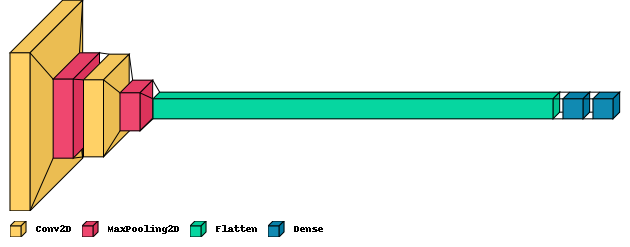

In [44]:
Simple_CNN = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
                           input_shape = (imagesize[0], imagesize[1], 3)), 

    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

Simple_CNN.compile(optimizer = keras.optimizers.RMSprop(lr=0.00001,decay=1e-6), 
                   loss = 'binary_crossentropy', metrics=['accuracy'])

visualkeras.layered_view(Simple_CNN, scale_xy =1, legend=True)

In [48]:
%%capture
history = Simple_CNN.fit(train_gen, epochs=25, validation_data = val_gen,
                     callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=5)])


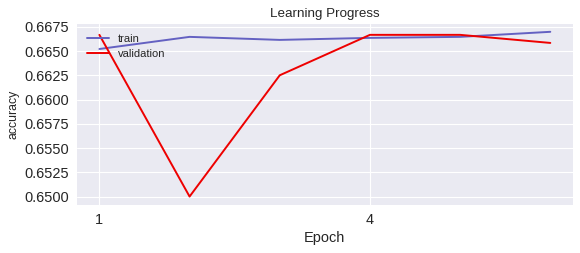

In [49]:
plot_training(history, 'accuracy', 'val_accuracy')

----------------------------------------------------------------
Evaluation of Sequential RNN on Test-Set
38/38 [==============================] - 0s 9ms/step
Accuracy Score: 0.67
Recall Score: 1.00
Precision Score: 0.67
AUC: 0.50


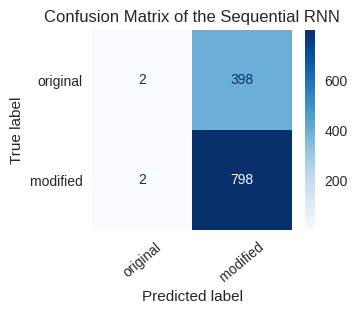

----------------------------------------------------------------
----------------------------------------------------------------


In [50]:
_ = evaluate_model(Simple_CNN, "Sequential RNN", 
               ["original", "manipulated"], testX, testY, skip_train=True)

**Error Analysis: The Imbalance Problem**

As we can see from the out oput of the confusion matrix, our Deep Learning model has problems  is having a bias problem

### 3.2.2. CNN with dropout & Weights

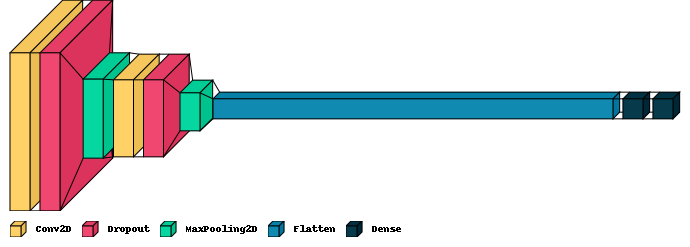

In [31]:
CNN_with_dropout = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
                           input_shape = (imagesize[0], imagesize[1], 3)), 
                           
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

CNN_with_dropout.compile(optimizer = keras.optimizers.RMSprop(lr=0.1,decay=1e-6), 
                         loss = 'binary_crossentropy', metrics=['accuracy'])
visualkeras.layered_view(CNN_with_dropout, scale_xy = 1, legend=True)
#tf.keras.utils.plot_model(model, show_dtype=False, dpi = 70)

**Add Class weights**

In [18]:
# show the imbalance problem again
print(len(np.where(trainY == 1)[0]))
print(len(np.where(trainY == 0)[0]))


6400
3200


In [19]:
# compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(trainY),
                                        y = trainY                                                    
                                    )

# create a dictionary out of the data
c_weights = dict(zip(np.unique(trainY), class_weights))
c_weights

{0: 1.5, 1: 0.75}

**Search for Best Learning Rate**

In [22]:
%%capture
# saving the initial weights of the model
CNN_with_dropout.save_weights('./inital_weights.h5')

learning_rates = [0.1,  0.001,  0.0005, 0.0001, 0.0005]
#CNN_with_dropout.load_weights('./inital_weights.h5')

#set list to collect results
accuracy_results_list = []

for rate in learning_rates:
  # get inital weights
  CNN_with_dropout.load_weights('./inital_weights.h5')
  # set learning rate
  CNN_with_dropout.compile(optimizer = keras.optimizers.Adam(learning_rate=rate), 
                           loss = 'binary_crossentropy', metrics=['accuracy'])
  history = CNN_with_dropout.fit(train_gen, epochs=10, validation_data = val_gen,
                     class_weight=c_weights)
  _, accuracy_score, _, _, _ = evaluate_model(CNN_with_dropout, "Sequential RNN", 
                                              ["original", "manipulated"], 
                                              testX, testY, skip_train=True)
  accuracy_results_list.append(accuracy_score)

In [23]:
pd.DataFrame({"LearningRate": [str(i) for i in learning_rates],"Accurracy": accuracy_results_list})

,LearningRate,Accurracy
0,0.1,0.33
1,0.001,0.33
2,0.0005,0.33
3,0.0001,0.33
4,0.0005,0.67


In [34]:
%%capture
#CNN_with_dropout.load_weights('./inital_weights.h5')
CNN_with_dropout.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0005), 
                         loss = 'binary_crossentropy', metrics=['accuracy'])
history = CNN_with_dropout.fit(train_gen, epochs=25, 
                               validation_data = val_gen, class_weight=c_weights)


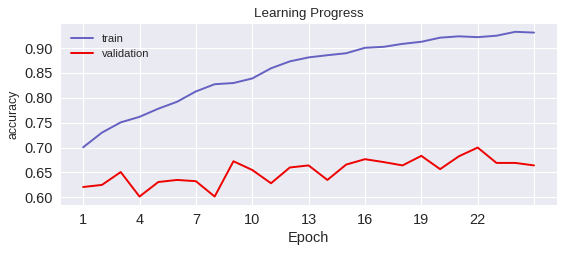

In [42]:
plot_training(history, 'accuracy', 'val_accuracy')

----------------------------------------------------------------
Evaluation of Sequential RNN on Test-Set
38/38 [==============================] - 0s 10ms/step
Accuracy Score: 0.67
Recall Score: 0.68
Precision Score: 0.80
AUC: 0.67


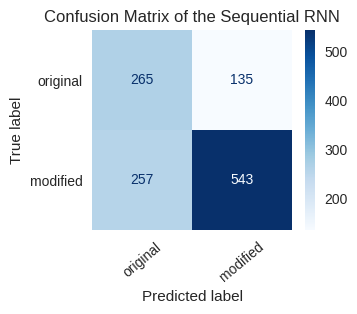

----------------------------------------------------------------
----------------------------------------------------------------


In [37]:
predictions, accuracy, recall, precision, AUC  = evaluate_model(CNN_with_dropout, 
                                                                "Sequential RNN", 
                                                                ["original", "manipulated"],
                                                                testX, testY, skip_train=True)

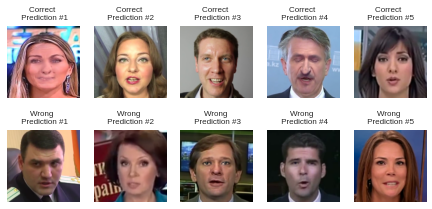

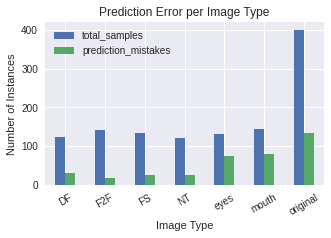

In [38]:
plot_right_and_wrong_predictions(predictions, testY, testType, 5)

### 3.2.3. Deep CNN

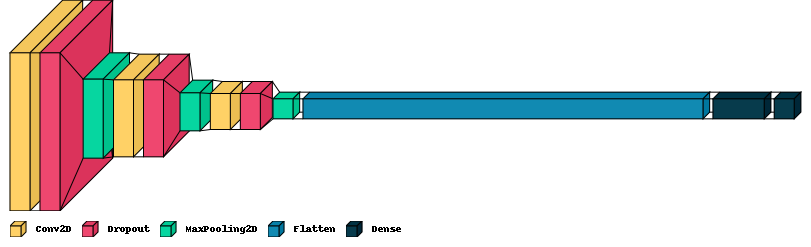

In [55]:
filter = 16


deep_CNN = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filter, (3, 3), activation = 'relu', input_shape = (imagesize[0], imagesize[1], 3)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filter*2, (3, 3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(filter*2*2, (3, 3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


# compile the model
deep_CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# look at it
visualkeras.layered_view(deep_CNN, scale_xy =1, legend=True)

In [61]:
%%capture
history = deep_CNN.fit(train_gen,  epochs=35, validation_data = val_gen,
                     callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=10)],
                     class_weight=c_weights)

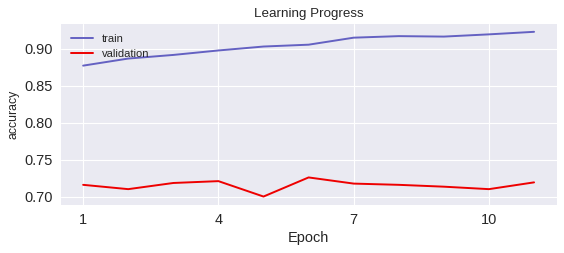

In [62]:
plot_training(history, 'accuracy', 'val_accuracy')

----------------------------------------------------------------
Evaluation of Deep CNN on Test-Set
38/38 [==============================] - 0s 9ms/step
Accuracy Score: 0.71
Recall Score: 0.76
Precision Score: 0.80
AUC: 0.68


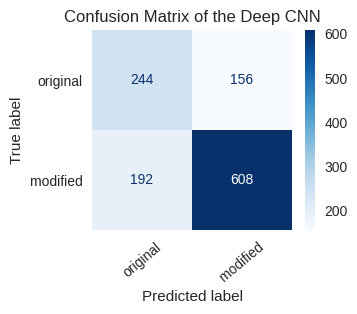

----------------------------------------------------------------
----------------------------------------------------------------


In [65]:
predictions, accuracy, _, _, _  = evaluate_model(deep_CNN, "Deep CNN", ["original", "manipulated"], testX, testY, skip_train=True)

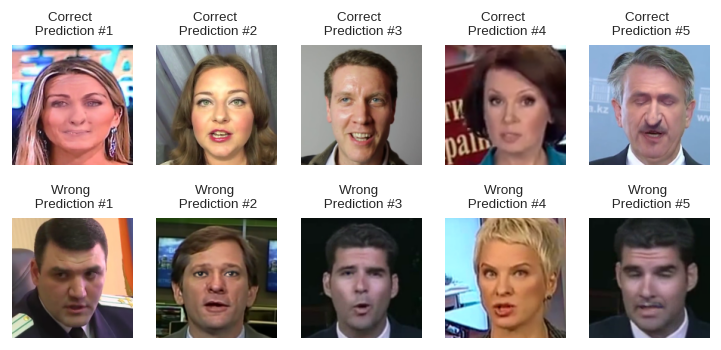

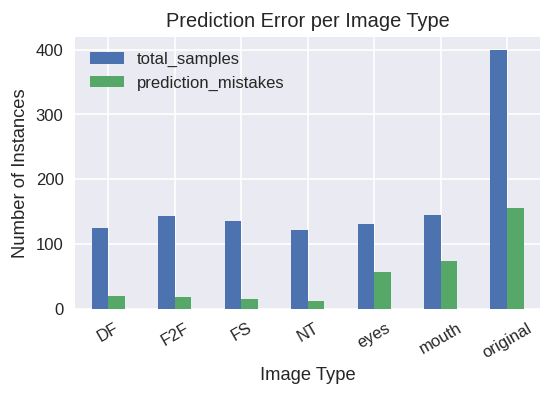

In [66]:
plot_right_and_wrong_predictions(predictions, testY, testType, 5)

#### 3.2.4 Efficient Net

Note: For Efficent Net we have reduced the number of samples else we run
into a Graph execution error

In [75]:
batch_size = 30
train_gen = BatchGenerator(trainX, trainY, batch_size)
val_gen = BatchGenerator(valX, valY, batch_size)
test_gen = BatchGenerator(testX, testY, batch_size)

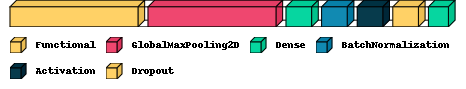

In [76]:


eff_net = tf.keras.Sequential([
    tf.keras.applications.efficientnet.EfficientNetB0(weights=None,
                                                      include_top=False,  input_shape = (imagesize[0], imagesize[1], 3)),

    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(256, activation=tf.nn.softmax, use_bias=False),

    tf.keras.layers.BatchNormalization(name='batch_norm2'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile the model
eff_net.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# look at it
visualkeras.layered_view(eff_net, scale_xy =1, legend=True)


In [ ]:
%%capture
history = eff_net.fit(train_gen, epochs=40, validation_data = val_gen,
                     #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=15)],
                     class_weight=c_weights)

In [ ]:
plot_training(history, 'accuracy', 'val_accuracy')

16705208/16705208 [==============================] - 0s 0us/step


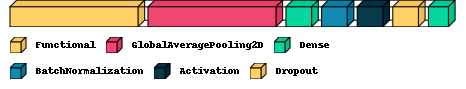

In [ ]:


eff_net = tf.keras.Sequential([
    tf.keras.applications.efficientnet.EfficientNetB0(weights="imagenet",
                                                      include_top=False,  input_shape = (imagesize[0], imagesize[1], 3)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation=tf.nn.softmax, use_bias=False),

    tf.keras.layers.BatchNormalization(name='batch_norm2'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile the model
eff_net.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
# look at it
visualkeras.layered_view(eff_net, scale_xy =1, legend=True)


In [ ]:
history = eff_net.fit(train_gen, epochs=10, validation_data = val_gen,
                     #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=8)])
                     class_weight=c_weights)

Epoch 1/10
1920/1920 [==============================] - 97s 51ms/step - loss: 0.6932 - accuracy: 0.5603 - val_loss: 0.6935 - val_accuracy: 0.4083
Epoch 2/10
1920/1920 [==============================] - 92s 48ms/step - loss: 0.6933 - accuracy: 0.4882 - val_loss: 0.7059 - val_accuracy: 0.3333
Epoch 3/10
1920/1920 [==============================] - 92s 48ms/step - loss: 0.6933 - accuracy: 0.4625 - val_loss: 0.6955 - val_accuracy: 0.3383
Epoch 4/10
1920/1920 [==============================] - 92s 48ms/step - loss: 0.6933 - accuracy: 0.4503 - val_loss: 0.6938 - val_accuracy: 0.3333
Epoch 5/10
1920/1920 [==============================] - 92s 48ms/step - loss: 0.6933 - accuracy: 0.4766 - val_loss: 0.6930 - val_accuracy: 0.4125
Epoch 6/10
1920/1920 [==============================] - 92s 48ms/step - loss: 0.6933 - accuracy: 0.4530 - val_loss: 0.6934 - val_accuracy: 0.3358
Epoch 7/10
1920/1920 [==============================] - 91s 48ms/step - loss: 0.6933 - accuracy: 0.4921 - val_loss: 0.6930 -

In [ ]:
plot_training(history, 'accuracy', 'val_accuracy')

## 5. Appendix

### 5.1. Upsampling

was finally not used because applying class weights works better and more efficient

In [ ]:
print(len(np.where(trainY==0)[0]))
print(len(np.where(trainY==1)[0]))
additional_X_data = trainX[np.where(trainY==0)[0]]
additional_Y_data = trainY[np.where(trainY==0)[0]]
trainY = np.append(trainY, additional_Y_data)
trainX = np.append(trainX, additional_X_data, axis=0)

# shuffle data again
trainX, trainY = shuffle(trainX, trainY)
print(len(trainX))
print(len(trainY))

print(len(np.where(trainY==0)[0]))
print(len(np.where(trainY==1)[0]))

3200
6400
12800
12800
6400
6400
